# Introduction
## What we are trying to accomplish
In general we are trying to provide answers to the following questions:
- How is the adoption of renewable energy in Europe evolving?
- How is the adoption of different types of renewable energy evolving?
- Are there characteristics of countries that correlate with their level of adoption of renewable energy?

### Main Questions
As these questions are defined very broadly and can be answered in a variety of ways, we decided to formulate the following more discreet questions, focusing on the production and consumption of renewable energy in europe:
- How has the adoption of renewable energy in Europe developed over time?
- Which types of renewable energy have been predominantly adopted?

### Sub Questions
- How do economic factors like GDP influence the adoption of renewable energy?


## Data Description
We are using the dataset from [Kaggle](https://www.kaggle.com/datasets/programmerrdai/renewable-energy/data). The general description can be found at the original [ourworldindata.org](https://ourworldindata.org/grapher/installed-solar-pv-capacity#:~:text=IRENA%20%E2%80%93%20Renewable%20Capacity-,Statistics) data source.
**Absolute Values:** Absolute measurements are represented in megawatts (MW) rounded to the nearest one megawatt, with figures between zero and 0.5MW shown as a 0.
**Shares:** Shares are represented as percentages

## Exploring the data
Load all required packages and modules

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

The dataset contains a wide range of data from different countries and time ranges. In this exercise we chose to only consider **european** countries and compare them to the overall european and global trends. We take the **years (1990-2020)** into consideration to answer our questions.

In [2]:
# ISO codes for European countries
country_codes = (
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT',
    'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'GBR')
entities = ('Europe', 'World')
time_window = (1980, 2020)

We clean the data by:
- Handling all NaN by dropping them
- Removing all non-European countries
- Only consider our targeted time window (1990-2020)

In [3]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    #df = df.dropna()

    # Only Use European Countries & Europe/World accumulated data
    df = df[(df['Code'].isin(country_codes)) | (df['Entity'].isin(entities))]
    #df = df[(df['Entity'] == 'Europe')]

    # Only consider data from (1990-2020)
    if 'Year' in df.columns:
        df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df = df[(df['Year'] >= time_window[0]) & (df['Year'] <= time_window[1])]

    df.reset_index(drop=True, inplace=True)

    return df

Put it all together and read and clean the dataframes:

In [4]:
def read_and_clean_csv(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = clean_df(df)
    return df

folder_path = os.path.join('..', 'data')
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

dataframes = {os.path.basename(file).split('.')[0]: clean_df(read_and_clean_csv(file)) for file in csv_files}

### Merge semantically relevant dataframes
Now we merge dataframes that contain semantically relevant data into one. These are:
- `share_energy:` merged from `hydro-share-energy`,`solar-share-energy`,`wind-share-energy`,`renewable-share-energy`
- `share_electricity:` merged from `share-electricity-hydro`,`share-electricity-solar`,`share-electricity-solar`,`share-electricity-wind`,`share-electricity-renewables`



In [5]:
def merge_share_dfs(dfs: dict[str: pd.DataFrame], sub_str: str) -> pd.DataFrame:
    relevant_keys = [key for key in dfs.keys() if sub_str in key]
    filtered_dfs = dfs[relevant_keys[0]]
    for key in relevant_keys[1:]:
        filtered_dfs = filtered_dfs.merge(
            dfs[key],
            on=['Entity', 'Code', 'Year'],
            how='outer',
        )
    return filtered_dfs

share_energy_long = merge_share_dfs(dataframes, 'share-energy')
share_electricity_long = merge_share_dfs(dataframes, 'share-electricity')

Add 'Other Renewables' Column

In [6]:
share_energy_long['Other Renewables (% sub energy)'] = share_energy_long['Renewables (% sub energy)'] - ((share_energy_long['Solar (% sub energy)']) + (share_energy_long['Hydro (% sub energy)']) + (share_energy_long['Wind (% sub energy)']))
share_electricity_long['Other Renewables (% electricity)'] = share_electricity_long['Renewables (% electricity)'] - ((share_electricity_long['Solar (% electricity)']) + (share_electricity_long['Hydro (% electricity)']) + (share_electricity_long['Wind (% electricity)']))

### Multi-Index
These newly merged frames can now be converted from a long format to a wide multi-index dataformat.

In [7]:
share_energy = share_energy_long.set_index(['Entity','Code', 'Year'])
share_electricity = share_electricity_long.set_index(['Entity','Code', 'Year'])

### Check the Data

In [8]:
print("Merged 'share_energy' DataFrame:")
display(share_energy)

print("\nMerged 'share_electricity' DataFrame:")
display(share_electricity)

print(share_energy.info())
print(share_energy)

Merged 'share_energy' DataFrame:


Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Code     Year                                                    
Austria AUT      1980                25.617                     25.617   
                 1981                28.003                     28.003   
                 1982                29.015                     29.015   
                 1983                28.818                     28.818   
                 1984                25.484                     25.484   
...                                     ...                        ...   
World   OWID_WRL 2016                 6.594                     10.239   
                 2017                 6.515                     10.618   
                 2018                 6.486                     10.978   
                 2019                 6.481                     11.437   
                 2020                 6.856                     12.553   

                       Solar (% sub energy)  Wind (% sub energy)  \
Entity  Code     Year                                              
Austria AUT      1980                 0.000                0.000   
                 1981                 0.000                0.000   
                 1982                 0.000                0.000   
                 1983                 0.000                0.000   
                 1984                 0.000                0.000   
...                                     ...                  ...   
World   OWID_WRL 2016                 0.539                1.579   
                 2017                 0.715                1.827   
                 2018                 0.896                1.972   
                 2019                 1.085                2.174   
                 2020                 1.365                2.539   

                       Other Renewables (% sub energy)  
Entity  Code     Year                                   
Austria AUT      1980                            0.000  
                 1981                            0.000  
                 1982                            0.000  
                 1983                            0.000  
                 1984                            0.000  
...                                                ...  
World   OWID_WRL 2016                            1.527  
                 2017                            1.561  
                 2018                            1.624  
                 2019                            1.697  
                 2020                            1.793  

[1277 rows x 5 columns]


Merged 'share_electricity' DataFrame:


Hydro (% electricity)  Renewables (% electricity)  \
Entity  Code     Year                                                      
Austria AUT      1985                 69.103                      69.103   
                 1986                 69.209                      72.092   
                 1987                 70.050                      71.843   
                 1988                 72.014                      74.149   
                 1989                 69.922                      72.123   
...                                      ...                         ...   
World   OWID_WRL 2016                 16.531                      24.256   
                 2017                 16.277                      25.076   
                 2018                 16.129                      25.763   
                 2019                 16.048                      26.711   
                 2020                 16.516                      28.522   

                       Solar (% electricity)  Wind (% electricity)  \
Entity  Code     Year                                                
Austria AUT      1985                  0.000                 0.000   
                 1986                  0.000                 0.000   
                 1987                  0.000                 0.000   
                 1988                  0.000                 0.000   
                 1989                  0.000                 0.000   
...                                      ...                   ...   
World   OWID_WRL 2016                  1.358                 3.965   
                 2017                  1.782                 4.570   
                 2018                  2.196                 4.906   
                 2019                  2.642                 5.401   
                 2020                  3.197                 6.079   

                       Other Renewables (% electricity)  
Entity  Code     Year                                    
Austria AUT      1985                             0.000  
                 1986                             2.883  
                 1987                             1.793  
                 1988                             2.135  
                 1989                             2.201  
...                                                 ...  
World   OWID_WRL 2016                             2.402  
                 2017                             2.447  
                 2018                             2.532  
                 2019                             2.620  
                 2020                             2.730  

[1173 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1277 entries, ('Austria', 'AUT', np.int64(1980)) to ('World', 'OWID_WRL', np.int64(2020))
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Hydro (% sub energy)             1277 non-null   float64
 1   Renewables (% sub energy)        1277 non-null   float64
 2   Solar (% sub energy)             1277 non-null   float64
 3   Wind (% sub energy)              1277 non-null   float64
 4   Other Renewables (% sub energy)  1277 non-null   float64
dtypes: float64(5)
memory usage: 57.7+ KB
None
                       Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Code     Year                                                    
Austria AUT      1980                25.617                     25.617   
                 1981                28.003                     28.003   
                 1982                29.015        

### Noticing Trends
Now let's create some plots in order to better observe certain trends

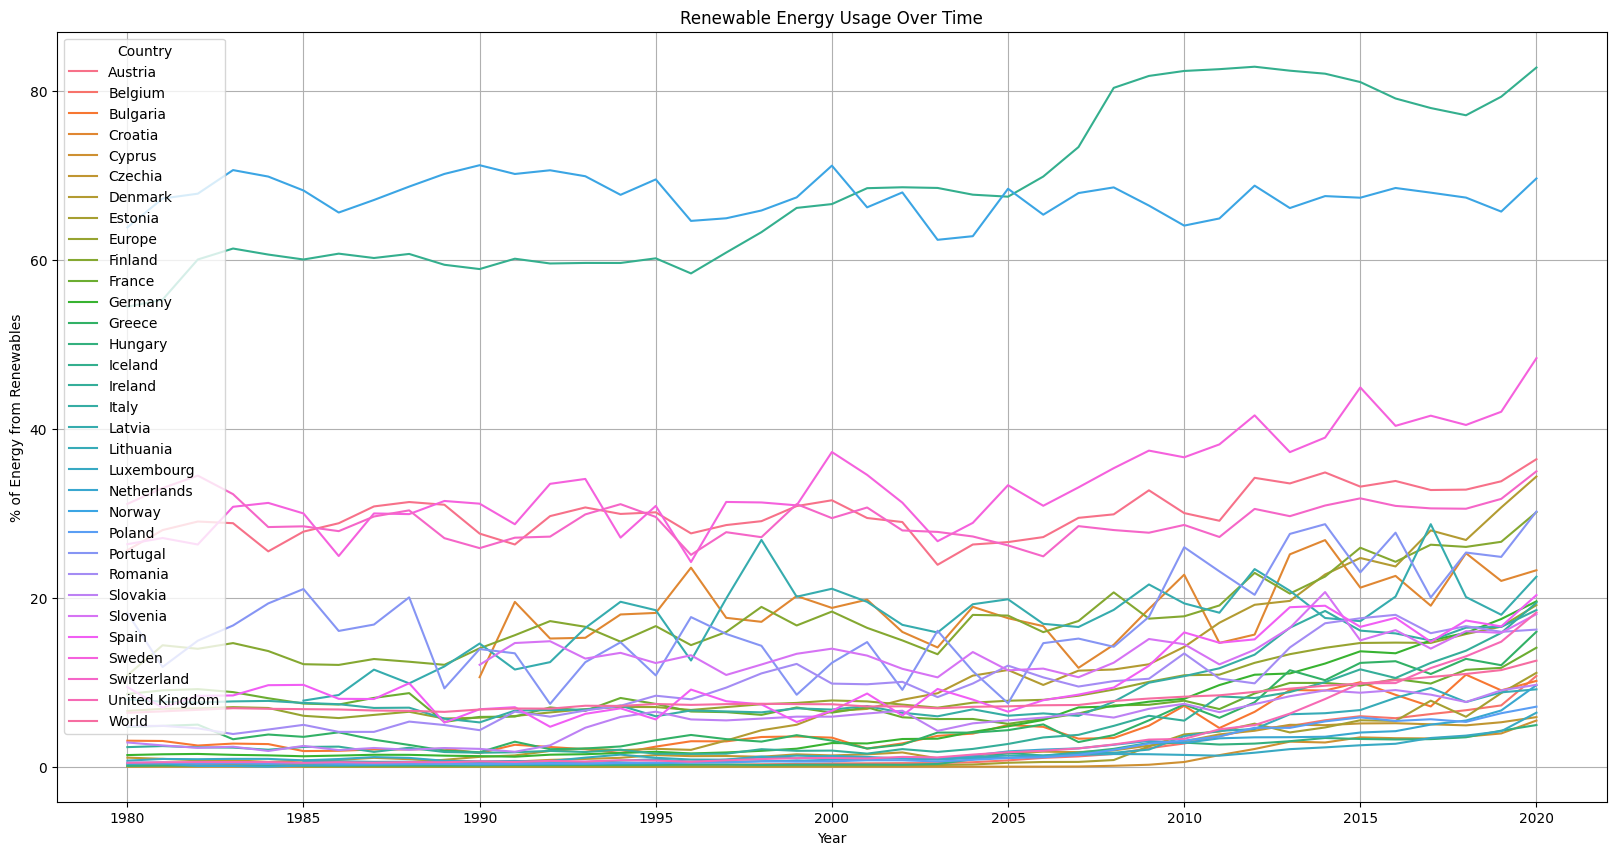

In [9]:
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Plot renewables over time for selected countries
plt.figure(figsize=(20, 10))
sns.lineplot(data=data_filtered, x='Year', y='Renewables (% sub energy)', hue='Entity')
plt.title('Renewable Energy Usage Over Time')
plt.ylabel('% of Energy from Renewables')
plt.xlabel('Year')
plt.legend(title='Country')
plt.grid(True)
plt.show()

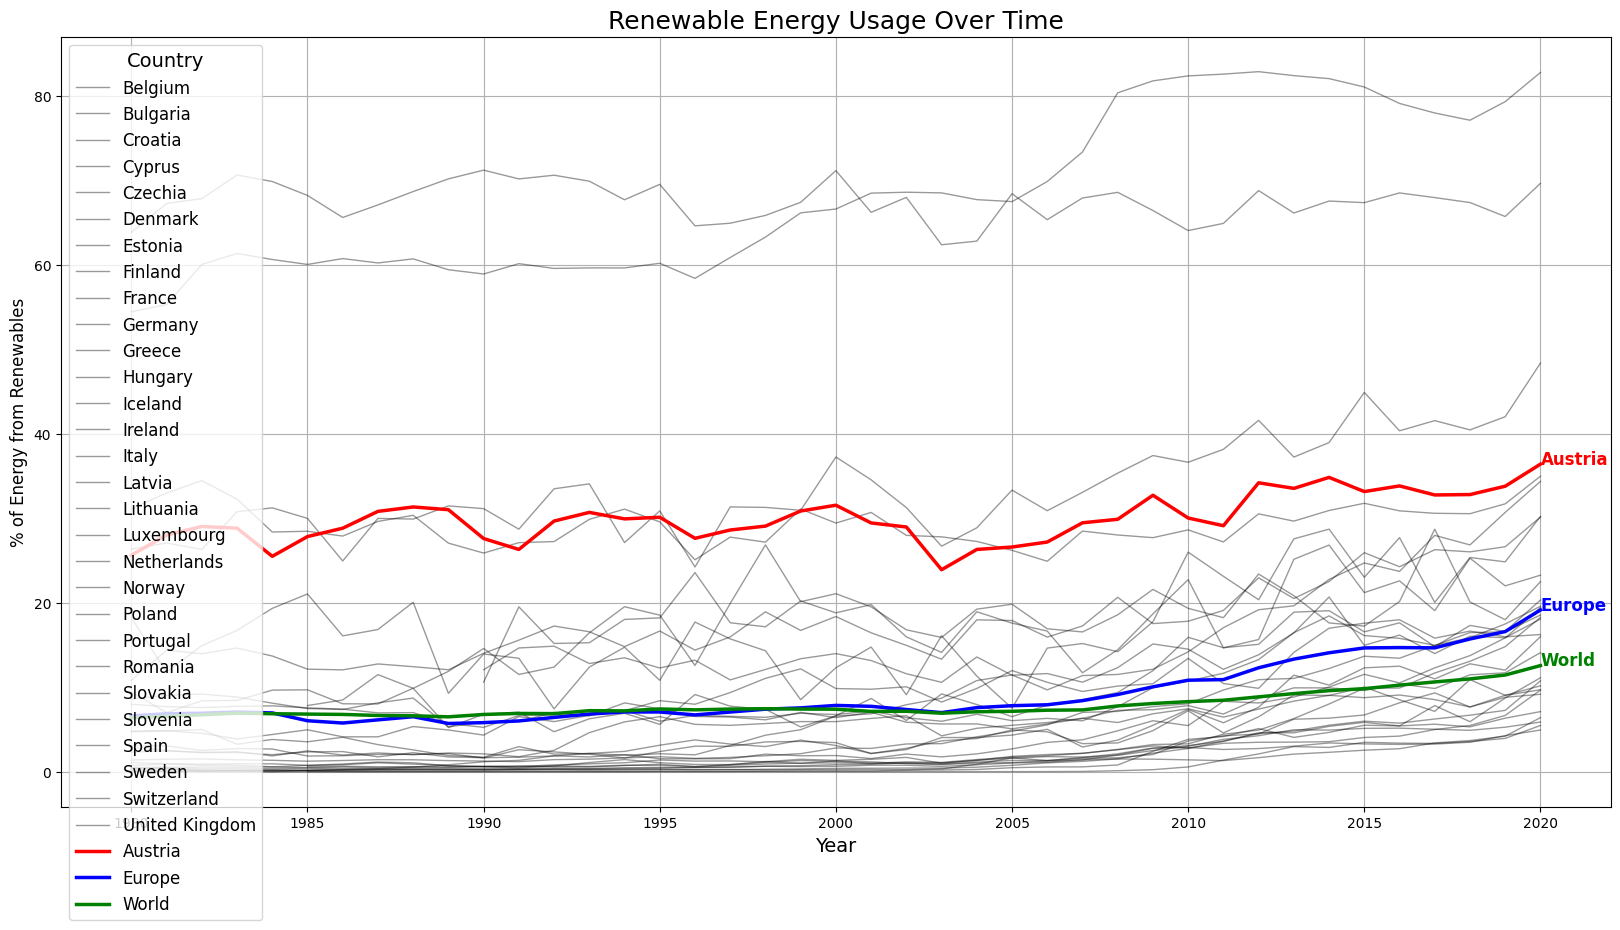

In [10]:
# Filter data for specific countries
countries = ['Austria', 'Belgium', 'Czechia', 'Europe', 'France', 'Germany', 'Spain', 'Norway', 'Romania', 'United Kingdom', 'World']
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'black' for country in data_filtered['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

# Plot
plt.figure(figsize=(20, 10))

# Plot all countries with lighter lines
sns.lineplot(
    data=data_filtered[~data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, alpha=0.4, linewidth=1
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=data_filtered[data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, linewidth=2.5
)

# Add titles and labels
plt.title('Renewable Energy Usage Over Time', fontsize=18)
plt.ylabel('% of Energy from Renewables', fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Country', fontsize=12, title_fontsize=14)
plt.grid(True)

# Highlight lines with direct annotations
for country in standout_countries:
    country_data = data_filtered[data_filtered['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Renewables (% sub energy)'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.show()

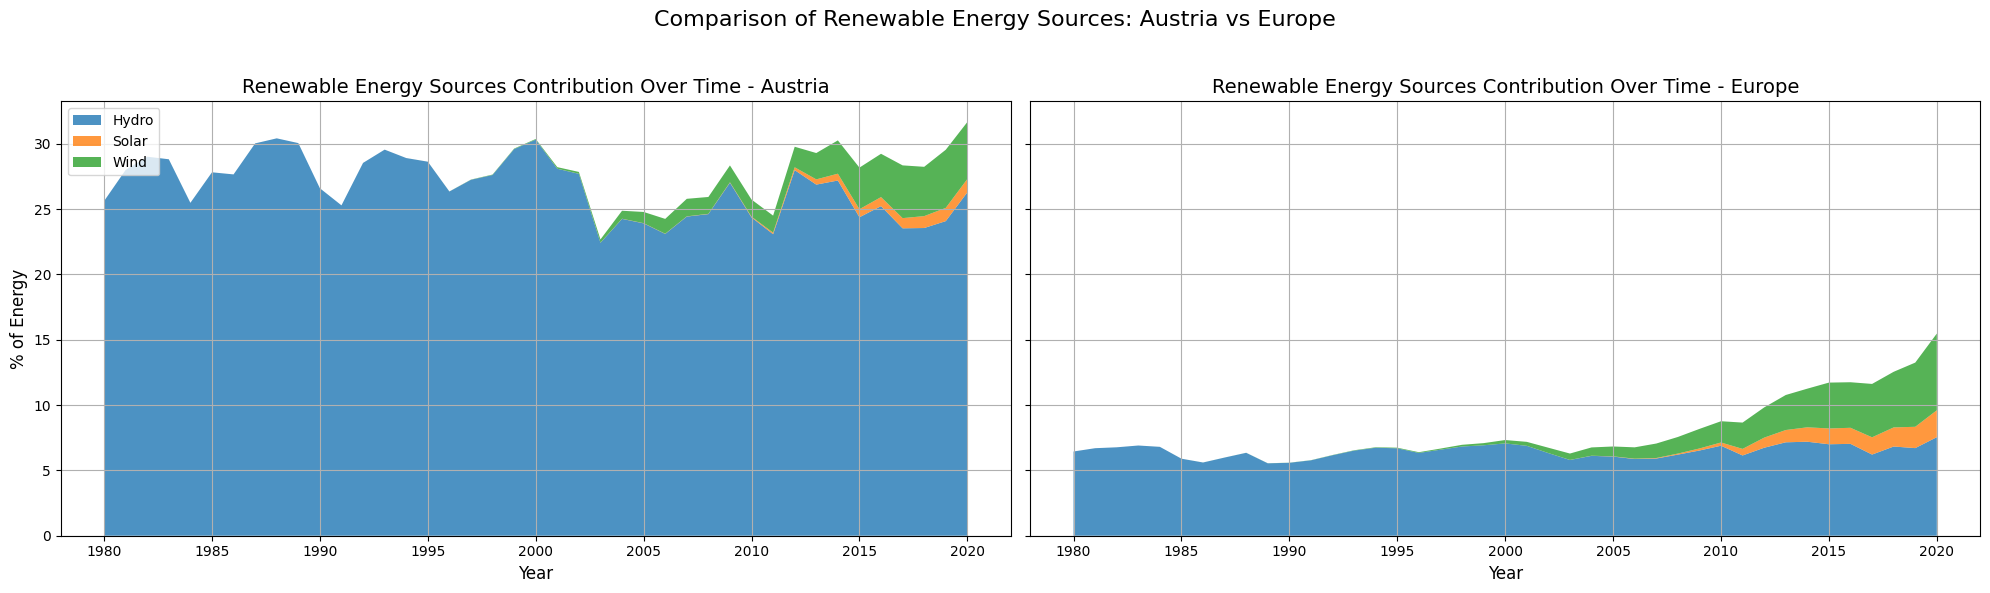

In [11]:
# Select data for Austria
country_austria = 'Austria'
data_austria = share_energy.loc[country_austria].reset_index()

# Select data for Europe
country_europe = 'Europe'
data_europe = share_energy.loc[country_europe].reset_index()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for Austria
axes[0].stackplot(
    data_austria['Year'],
    data_austria['Hydro (% sub energy)'],
    data_austria['Solar (% sub energy)'],
    data_austria['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[0].set_title(f'Renewable Energy Sources Contribution Over Time - {country_austria}', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('% of Energy', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot for Europe
axes[1].stackplot(
    data_europe['Year'],
    data_europe['Hydro (% sub energy)'],
    data_europe['Solar (% sub energy)'],
    data_europe['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[1].set_title(f'Renewable Energy Sources Contribution Over Time - {country_europe}', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.suptitle('Comparison of Renewable Energy Sources: Austria vs Europe', fontsize=16)
plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

Even though we only have specific data for Hydro, Solar and Wing generation, there other renewable ways of generating energy. To show how much data we are missing on other renewable energy types, we plotted the most recent (2020) energy usage.

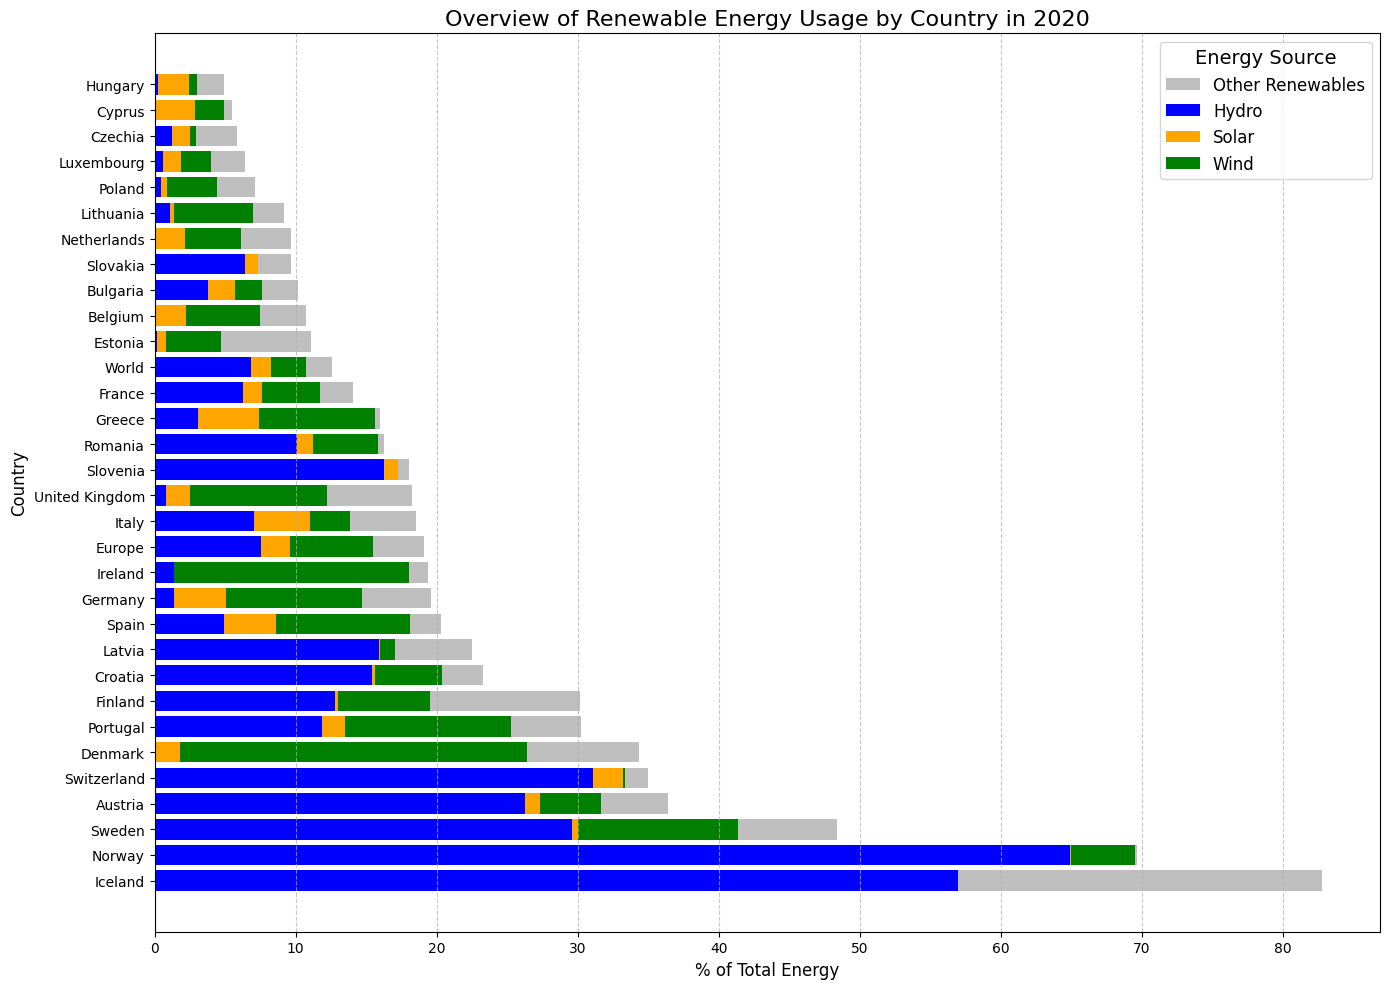

In [12]:
# Filter the data for the year 2020
data_2020 = share_energy.xs(key=2020, level='Year')

# Sort by total renewables for better visualization
data_2020 = data_2020.sort_values(by='Renewables (% sub energy)', ascending=False)

# Create a stacked bar plot
plt.figure(figsize=(14, 10))

# Plot the total renewable energy as a separate bar beforehand
# This makes it show up as the other types of renewable energy that we are missing (e.g. not in hydro, wind, solar)
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Renewables (% sub energy)'], label='Other Renewables', color='gray', alpha=0.5)

# Plot the stacked bars for Hydro, Solar, and Wind
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Solar (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'],
    label='Solar',
    color='orange'
)
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Wind (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'] + data_2020['Solar (% sub energy)'],
    label='Wind',
    color='green'
)

# Add labels and title
plt.title('Overview of Renewable Energy Usage by Country in 2020', fontsize=16)
plt.xlabel('% of Total Energy', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Energy Source', fontsize=12, title_fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

## Which types of renewable energy have been predominantly adopted?
Plot how the percentage of renewable energy from different sources (Hydro, Solar, Wind, and Other Renewables) has changed globally, to get an overall view.

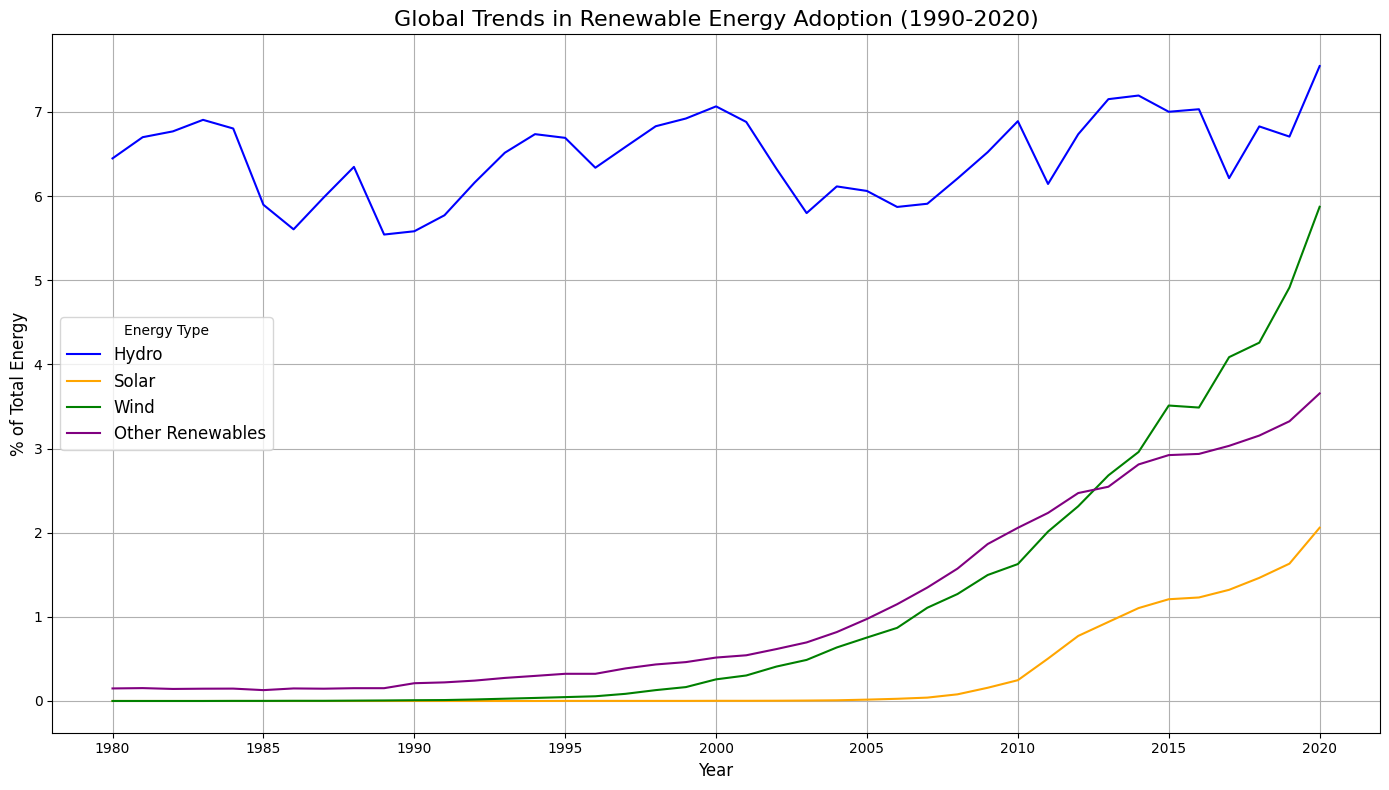

In [13]:
# Filter for global data (use 'World' as the entity)
share_energy_europe = share_energy.xs(key='Europe', level='Entity')

# TODO replace with seaborn
# Plot trends in renewable energy types (Hydro, Solar, Wind, Other Renewables) globally
plt.figure(figsize=(14, 8))
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Solar (% sub energy)'], label='Solar', color='orange')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Wind (% sub energy)'], label='Wind', color='green')
plt.plot(share_energy_europe.index.get_level_values('Year'), share_energy_europe['Other Renewables (% sub energy)'], label='Other Renewables', color='purple')

plt.title('Global Trends in Renewable Energy Adoption (1990-2020)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('% of Total Energy', fontsize=12)
plt.legend(title='Energy Type', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Determine the dominant renewable energy source by calculating the mean share for each source over time

In [14]:
# Calculate the average percentage of each renewable energy type globally over time
mean_renewables = share_energy_europe[['Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']].mean()

# Sort to identify the most dominant energy type
mean_renewables_sorted = mean_renewables.sort_values(ascending=False)

# Print the result
print(f"Most Predominantly Adopted Renewable Energy Types (Mean over Time):\n{mean_renewables_sorted}")

Most Predominantly Adopted Renewable Energy Types (Mean over Time):
Hydro (% sub energy)               6.471561
Wind (% sub energy)                1.119829
Other Renewables (% sub energy)    1.119195
Solar (% sub energy)               0.312780
dtype: float64


Another interesting analysis is to see which year had the highest adoption of each energy source.

In [15]:
# Find the year with the highest percentage for each renewable energy type globally
max_renewables_year = share_energy_europe[['Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']].idxmax()

# Print the results
print(f"Year with the highest adoption of each renewable energy type:\n{max_renewables_year}")

Year with the highest adoption of each renewable energy type:
Hydro (% sub energy)               (nan, 2020)
Solar (% sub energy)               (nan, 2020)
Wind (% sub energy)                (nan, 2020)
Other Renewables (% sub energy)    (nan, 2020)
dtype: object


# Interesting statistics and relations
## Relation between energy and electricity

In [16]:
share_energy_electricity = pd.merge(
    share_energy,
    share_electricity,
    left_index=True,
    right_index=True,
    how='inner'
)
display(share_energy_electricity)

Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Code     Year                                                    
Austria AUT      1985                27.820                     27.820   
                 1986                27.659                     28.812   
                 1987                30.033                     30.802   
                 1988                30.420                     31.323   
                 1989                30.056                     31.002   
...                                     ...                        ...   
World   OWID_WRL 2016                 6.594                     10.239   
                 2017                 6.515                     10.618   
                 2018                 6.486                     10.978   
                 2019                 6.481                     11.437   
                 2020                 6.856                     12.553   

                       Solar (% sub energy)  Wind (% sub energy)  \
Entity  Code     Year                                              
Austria AUT      1985                 0.000                0.000   
                 1986                 0.000                0.000   
                 1987                 0.000                0.000   
                 1988                 0.000                0.000   
                 1989                 0.000                0.000   
...                                     ...                  ...   
World   OWID_WRL 2016                 0.539                1.579   
                 2017                 0.715                1.827   
                 2018                 0.896                1.972   
                 2019                 1.085                2.174   
                 2020                 1.365                2.539   

                       Other Renewables (% sub energy)  Hydro (% electricity)  \
Entity  Code     Year                                                           
Austria AUT      1985                            0.000                 69.103   
                 1986                            1.153                 69.209   
                 1987                            0.769                 70.050   
                 1988                            0.903                 72.014   
                 1989                            0.946                 69.922   
...                                                ...                    ...   
World   OWID_WRL 2016                            1.527                 16.531   
                 2017                            1.561                 16.277   
                 2018                            1.624                 16.129   
                 2019                            1.697                 16.048   
                 2020                            1.793                 16.516   

                       Renewables (% electricity)  Solar (% electricity)  \
Entity  Code     Year                                                      
Austria AUT      1985                      69.103                  0.000   
                 1986                      72.092                  0.000   
                 1987                      71.843                  0.000   
                 1988                      74.149                  0.000   
                 1989                      72.123                  0.000   
...                                           ...                    ...   
World   OWID_WRL 2016                      24.256                  1.358   
                 2017                      25.076                  1.782   
                 2018                      25.763                  2.196   
                 2019                      26.711                  2.642   
                 2020                      28.522                  3.197   

                       Wind (% electricity)  Other Renewables (% electricity)  
Entity  Code     Year                               

Let's examine correlations between renewable energy and renewable electricity.

In [17]:
correlation = share_energy_electricity[['Renewables (% sub energy)', 'Renewables (% electricity)']].corr()
print("Correlation between renewable energy and renewable electricity:")
print(correlation)

Correlation between renewable energy and renewable electricity:
                            Renewables (% sub energy)  \
Renewables (% sub energy)                    1.000000   
Renewables (% electricity)                   0.918956   

                            Renewables (% electricity)  
Renewables (% sub energy)                     0.918956  
Renewables (% electricity)                    1.000000  


Identify countries with the largest gaps between renewable energy and electricity in 2020.

### Visualizations

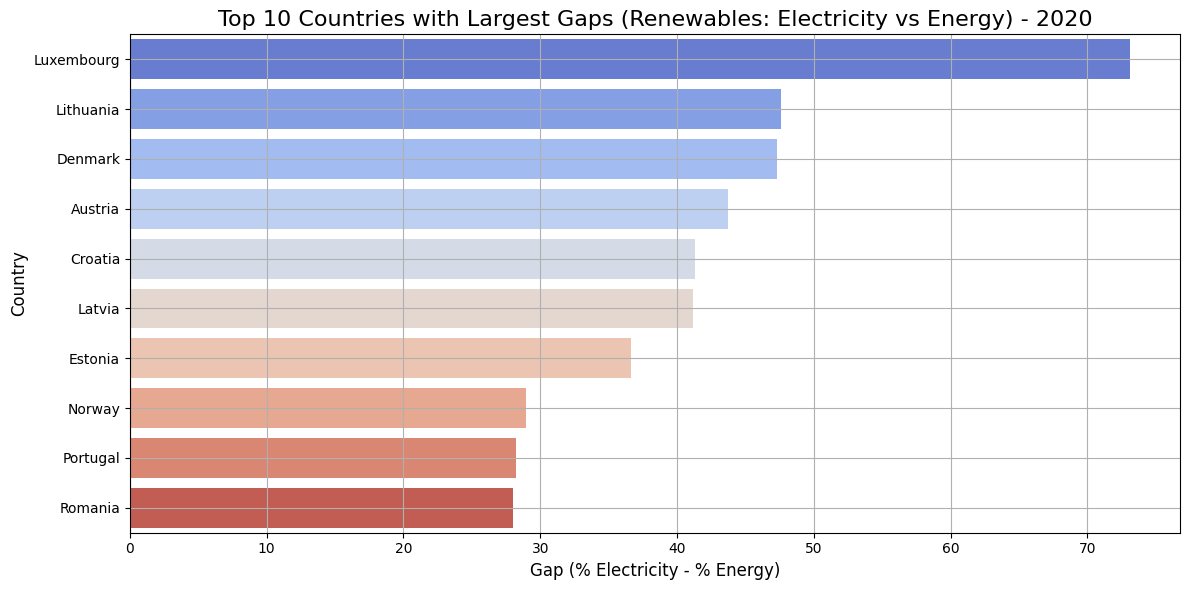

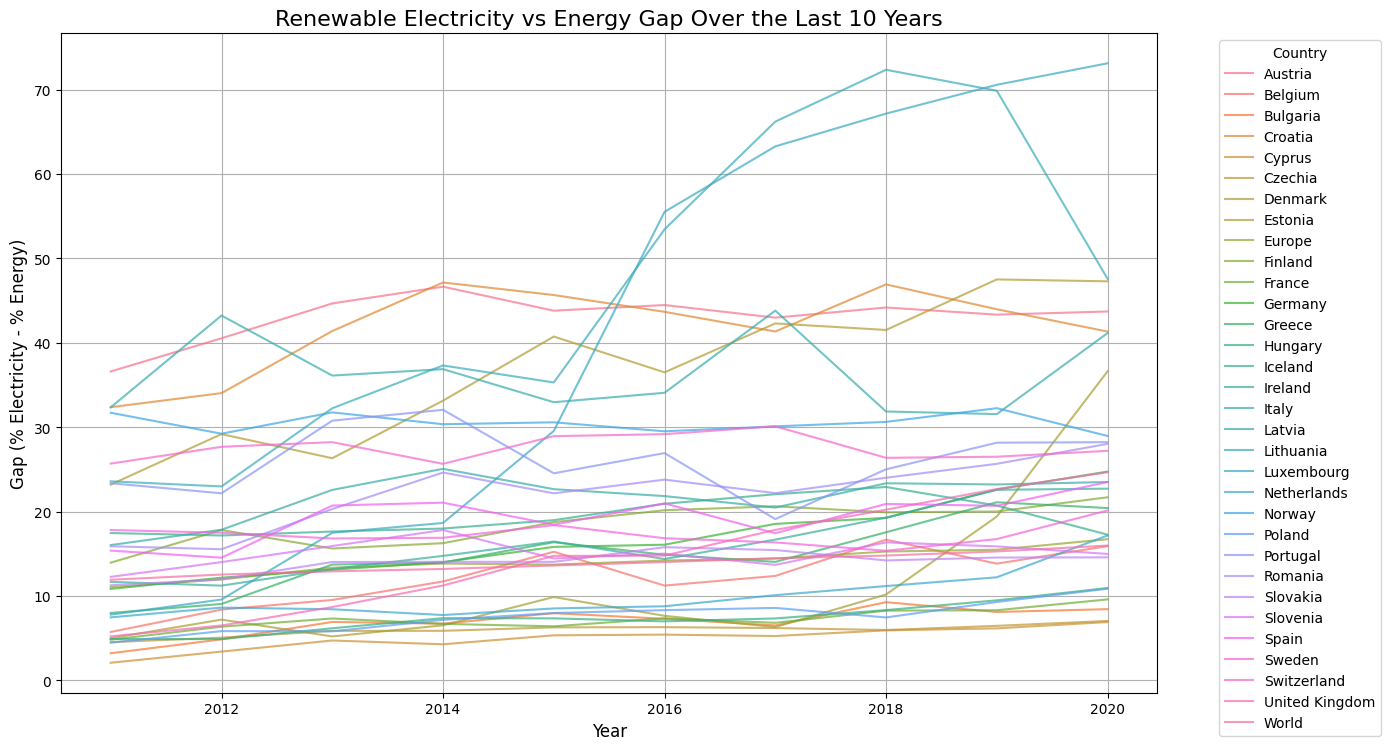

In [18]:
# Filter for the year 2020
data_2020 = share_energy_electricity.xs(key=2020, level='Year').copy()  # Use `.copy()` to avoid the warning

# Calculate the gap between Renewable Electricity and Renewable Energy
data_2020.loc[:, 'Gap'] = data_2020['Renewables (% electricity)'] - data_2020['Renewables (% sub energy)']

# Sort by the largest gap
largest_gaps = data_2020[['Gap']].sort_values(by='Gap', ascending=False).reset_index()

# Bar plot for the largest gaps in 2020
plt.figure(figsize=(12, 6))
sns.barplot(data=largest_gaps.head(10), x='Gap', y='Entity', palette='coolwarm', hue='Entity', dodge=False, legend=False)
plt.title('Top 10 Countries with Largest Gaps (Renewables: Electricity vs Energy) - 2020', fontsize=16)
plt.xlabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter for the last 10 years (2011–2020)
last_10_years = share_energy_electricity.loc[share_energy_electricity.index.get_level_values('Year') >= 2011].copy()

# Calculate the gap for each country and year
last_10_years.loc[:, 'Gap'] = last_10_years['Renewables (% electricity)'] - last_10_years['Renewables (% sub energy)']

# Reset index for plotting
gap_over_time = last_10_years.reset_index()

# Line plot for gaps over the last 10 years
plt.figure(figsize=(14, 8))
sns.lineplot(data=gap_over_time, x='Year', y='Gap', hue='Entity', alpha=0.7)

# Add labels and title
plt.title('Renewable Electricity vs Energy Gap Over the Last 10 Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.legend(title='Country', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Bar plot for largest gaps
plt.figure(figsize=(12, 6))
sns.barplot(data=largest_gaps.head(10), x='Gap', y='Country', palette='coolwarm')
plt.title('Top 10 Countries with Largest Gaps (Renewables: Electricity vs Energy) - 2020', fontsize=16)
plt.xlabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.grid(True)
plt.show()


ValueError: Could not interpret value `Country` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Code     Year                                                    
Austria AUT      1990                26.600                     27.586   
                 1991                25.290                     26.299   
                 1992                28.540                     29.655   
                 1993                29.555                     30.682   
                 1994                28.912                     29.914   
...                                     ...                        ...   
World   OWID_WRL 2016                 6.594                     10.239   
                 2017                 6.515                     10.618   
                 2018                 6.486                     10.978   
                 2019                 6.481                     11.437   
                 2020                 6.856                     12.553   

                       Hydro (% electricity)  Renewables (% electricity)  \
Entity  Code     Year                                                      
Austria AUT      1990                 63.915                      66.207   
                 1991                 62.654                      65.066   
                 1992                 69.770                      72.392   
                 1993                 71.462                      74.070   
                 1994                 68.528                      70.812   
...                                      ...                         ...   
World   OWID_WRL 2016                 16.531                      24.256   
                 2017                 16.277                      25.076   
                 2018                 16.129                      25.763   
                 2019                 16.048                      26.711   
                 2020                 16.516                      28.522   

                       Solar (% electricity)  Wind (% electricity)  \
Entity  Code     Year                                                
Austria AUT      1990                  0.000                 0.000   
                 1991                  0.000                 0.000   
                 1992                  0.000                 0.000   
                 1993                  0.000                 0.000   
                 1994                  0.000                 0.000   
...                                      ...                   ...   
World   OWID_WRL 2016                  1.358                 3.965   
                 2017                  1.782                 4.570   
                 2018                  2.196                 4.906   
                 2019                  2.642                 5.401   
                 2020                  3.197                 6.079   

                       Solar (% sub energy)  Wind (% sub energy)  \
Entity  Code     Year                                              
Austria AUT      1990                 0.000                0.000   
                 1991                 0.000                0.000   
                 1992                 0.000                0.000   
                 1993                 0.001                0.000   
                 1994                 0.001                0.000   
...                                     ...                  ...   
World   OWID_WRL 2016                 0.539                1.579   
                 2017                 0.715                1.827   
                 2018                 0.896                1.972   
                 2019                 1.085                2.174   
                 2020                 1.365                2.539   

                       Other Renewables (% electricity)  \
Entity  Code     Year                                     
Austria AUT      1990                             2.292   
                 1991                             2.412   
                 1992                  

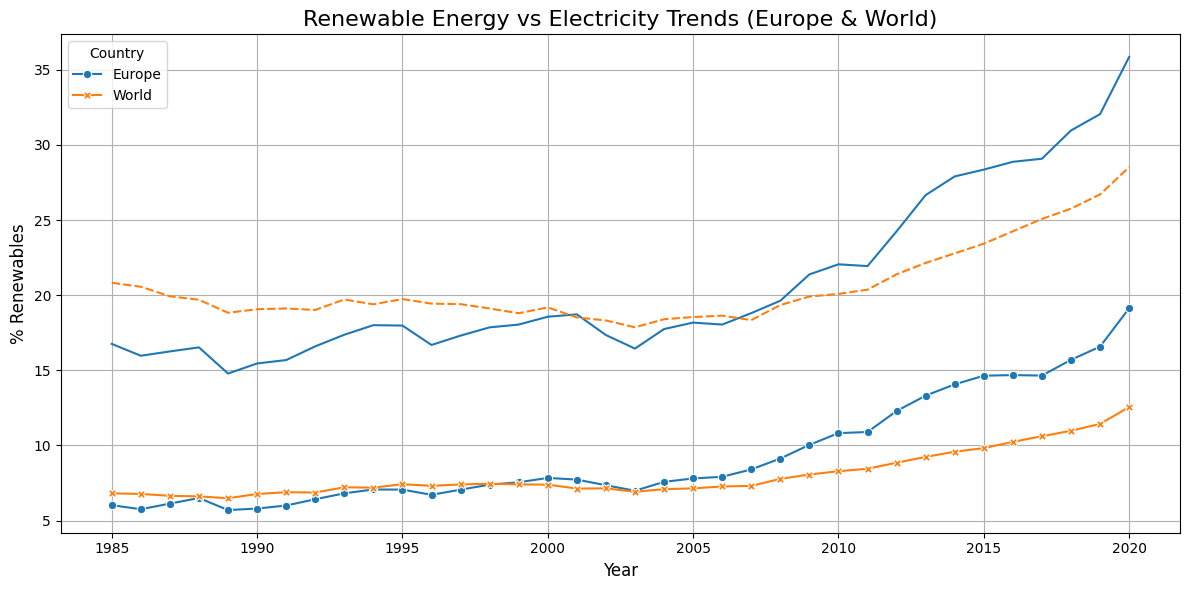

In [24]:
# Line plot for trends over time
# Define europe_world (if not already defined)
europe_world = share_energy_electricity.loc[
    share_energy_electricity.index.get_level_values('Entity').isin(['Europe', 'World'])
].reset_index()

europe_world.rename(columns={'Entity': 'Country'}, inplace=True)

# Line plot for trends over time
plt.figure(figsize=(12, 6))

# Plot for 'Renewables (% sub energy)'
sns.lineplot(
    data=europe_world,
    x='Year',
    y='Renewables (% sub energy)',
    hue='Country',
    style='Country',
    markers=True,
    dashes=False,
    legend="full"
)

# Plot for 'Renewables (% electricity)'
sns.lineplot(
    data=europe_world,
    x='Year',
    y='Renewables (% electricity)',
    hue='Country',
    style='Country',
    markers=False,
    dashes=True,
    legend=False  # Avoid duplicate legend
)

# Add plot titles and labels
plt.title('Renewable Energy vs Electricity Trends (Europe & World)', fontsize=16)
plt.ylabel('% Renewables', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Country')

# Add grid and show plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Line plot for trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=europe_world,
    x='Year',
    y='Renewables (% sub energy)',
    hue='Country',
    style='Country',
    markers=True,
    label='Renewables (% sub energy)'
)
sns.lineplot(
    data=europe_world,
    x='Year',
    y='Renewables (% electricity)',
    hue='Country',
    style='Country',
    dashes=True,
    label='Renewables (% electricity)'
)
plt.title('Renewable Energy vs Electricity Trends (Europe & World)', fontsize=16)
plt.ylabel('% Renewables', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Legend')
plt.grid(True)
plt.show()

NameError: name 'europe_world' is not defined

<Figure size 1200x600 with 0 Axes>

In [28]:
# Filter 2020 data
sources_2020 = data_2020[['Country', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)',
                          'Hydro (% electricity)', 'Solar (% electricity)', 'Wind (% electricity)']]

# Melt for easier plotting
melted = sources_2020.melt(id_vars='Country', var_name='Source', value_name='Percentage')

# Separate energy and electricity data
melted['Type'] = melted['Source'].apply(lambda x: 'Energy' if 'energy' in x else 'Electricity')
melted['Source'] = melted['Source'].str.replace(' (% sub energy)', '').str.replace(' (% electricity)', '')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted, x='Percentage', y='Country', hue='Type', palette='muted')
plt.title('Renewable Energy vs Electricity Breakdown by Source - 2020', fontsize=16)
plt.xlabel('% Contribution', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Type')
plt.grid(True)
plt.show()


KeyError: "['Country', 'Hydro (% electricity)', 'Solar (% electricity)', 'Wind (% electricity)'] not in index"

C:\Users\Michael Bayer\AppData\Local\Temp\ipykernel_34604\3261146893.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted, x='Percentage', y='Country', hue='Type', palette='muted', ci=None)


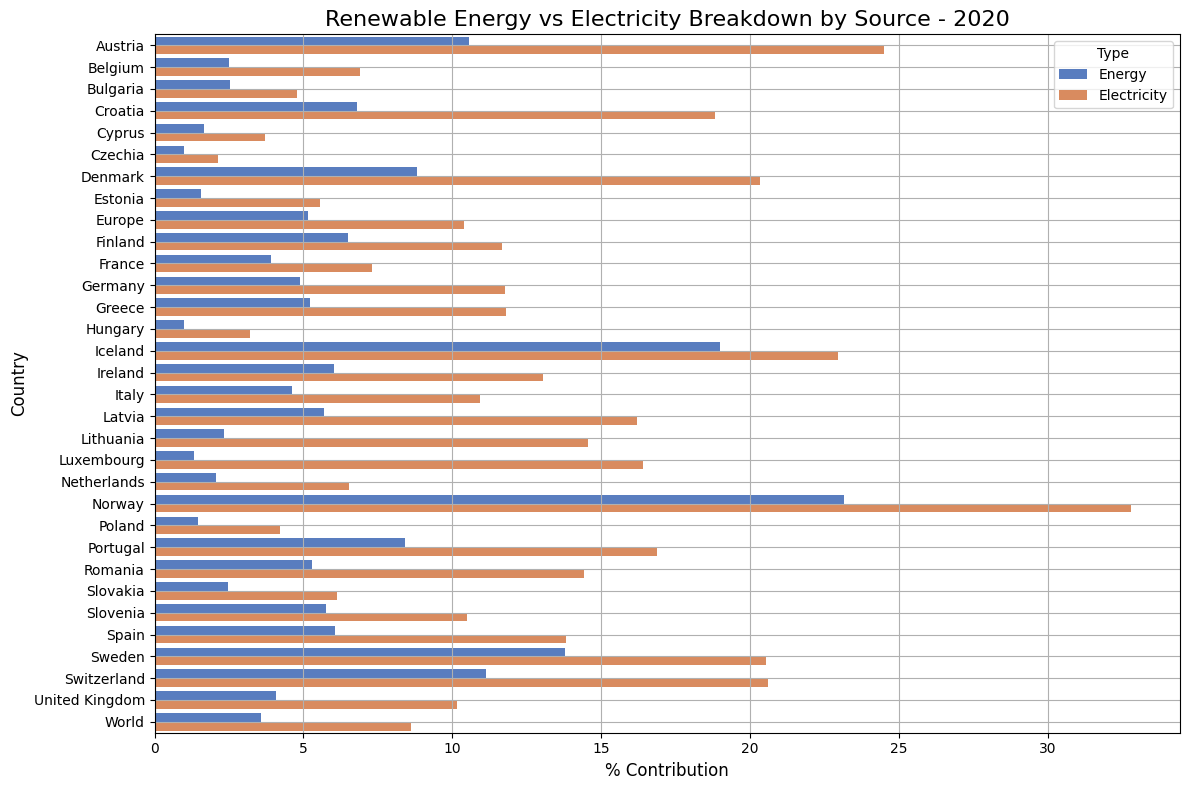

In [27]:
# Define data_2020 if not already available
data_2020 = share_energy_electricity.xs(key=2020, level='Year').reset_index()

# Filter relevant columns for 2020 data and explicitly create a copy
sources_2020 = data_2020[['Entity', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)',
                          'Hydro (% electricity)', 'Solar (% electricity)', 'Wind (% electricity)']].copy()

# Rename 'Entity' to 'Country' for consistency
sources_2020.rename(columns={'Entity': 'Country'}, inplace=True)

# Melt for easier plotting
melted = sources_2020.melt(id_vars='Country', var_name='Source', value_name='Percentage')

# Separate energy and electricity data
melted['Type'] = melted['Source'].apply(lambda x: 'Energy' if 'energy' in x else 'Electricity')
melted['Source'] = melted['Source'].str.replace(' (% sub energy)', '', regex=True).str.replace(' (% electricity)', '', regex=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted, x='Percentage', y='Country', hue='Type', palette='muted', ci=None)
plt.title('Renewable Energy vs Electricity Breakdown by Source - 2020', fontsize=16)
plt.xlabel('% Contribution', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Type')
plt.grid(True)
plt.tight_layout()
plt.show()



In [76]:
# Optionally, print the cleaned data for verification
for key, df in dataframes.items():
    print(f'{key}:')
    print(df.head(), '\n')

cumulative-installed-wind-energy-capacity-gigawatts:
    Entity Code  Year  Wind Capacity
0  Austria  AUT  1997          0.020
1  Austria  AUT  1998          0.030
2  Austria  AUT  1999          0.042
3  Austria  AUT  2000          0.050
4  Austria  AUT  2001          0.067 

share-electricity-hydro:
    Entity Code  Year  Hydro (% electricity)
0  Austria  AUT  1985                 69.103
1  Austria  AUT  1986                 69.209
2  Austria  AUT  1987                 70.050
3  Austria  AUT  1988                 72.014
4  Austria  AUT  1989                 69.922 

biofuel-production:
    Entity Code  Year  Biofuels Production - TWh - Total
0  Austria  AUT  1990                           0.073269
1  Austria  AUT  1991                           0.080247
2  Austria  AUT  1992                           0.089551
3  Austria  AUT  1993                           0.101181
4  Austria  AUT  1994                           0.067454 

hydropower-consumption:
    Entity Code  Year  Electricity fro

# Predictions for the future

In [77]:
# TODO: Train a model and crate a graph for how the future could look like?

data_filtered = data_filtered.dropna(subset=['Code'])

X = data_filtered[['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']]
y = data_filtered['Renewables (% sub energy)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],           
    'max_depth': [None, 10, 20, 30],            
    'min_samples_split': [2, 5, 10],             
    'min_samples_leaf': [1, 2, 4],               
    'max_features': ['sqrt', 'log2']            
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", (-grid_search.best_score_) ** 0.5)

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

test_rmse = mean_squared_error(y_test, y_pred)
print(f"Test Set RMSE with Best Model: {test_rmse}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None,

In [78]:
# Alternatively try out LASSO regression

data_filtered = data_filtered.sort_values(by=['Year'])
tscv = TimeSeriesSplit(n_splits=5)

lasso_model = Lasso(max_iter=10000, random_state=42)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best alpha found: ", grid_search.best_params_['alpha'])
print("Best cross-validation RMSE: ", (-grid_search.best_score_) ** 0.5)

best_lasso_model = grid_search.best_estimator_

y_pred = best_lasso_model.predict(X_test)

test_rmse = mean_squared_error(y_test, y_pred)
print(f"Test Set RMSE with Best Model: {test_rmse:.2f}")

feature_importance = pd.Series(best_lasso_model.coef_, index=X.columns)
print("Feature Importance (LASSO Coefficients):")
print(feature_importance)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ........................................

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

df = data_filtered.sort_values(by=['Year'])

X_columns = ['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']
scaler = StandardScaler()

best_alpha = 0.001  
lasso_model = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)


plt.figure(figsize=(12, 8))

for country in countries:
    country_df = df[df['Entity'] == country]
    
    X = country_df[X_columns]
    y = country_df['Renewables (% sub energy)']

    X_scaled = scaler.fit(X)

    lasso_model.fit(X_scaled, y)

    last_known_year = country_df['Year'].max()
    future_years = np.arange(last_known_year + 1, last_known_year + 51)

    future_data = []

    for feature in X_columns[1:]:  
        lr = LinearRegression()
        lr.fit(country_df[['Year']], country_df[feature])
        
        future_years_df = pd.DataFrame(future_years, columns=['Year'])
        future_feature_values = lr.predict(future_years_df)
        future_data.append(future_feature_values.flatten())

    future_data = np.column_stack([future_years] + future_data)

    future_df = pd.DataFrame(future_data, columns=X_columns)
    future_data_scaled = scaler.transform(future_df)
    future_predictions = lasso_model.predict(future_data_scaled)

    plt.plot(country_df['Year'], y, label=f'Actual {country}', linewidth=2)
    plt.plot(future_years, future_predictions, label=f'Predicted {country}', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Renewables (% sub energy)')
plt.title('Actual vs Predicted Renewables for Each Country (Next 50 Years)')
plt.legend()
plt.grid(True)
plt.show()


TypeError: float() argument must be a string or a real number, not 'StandardScaler'

<Figure size 1200x800 with 0 Axes>

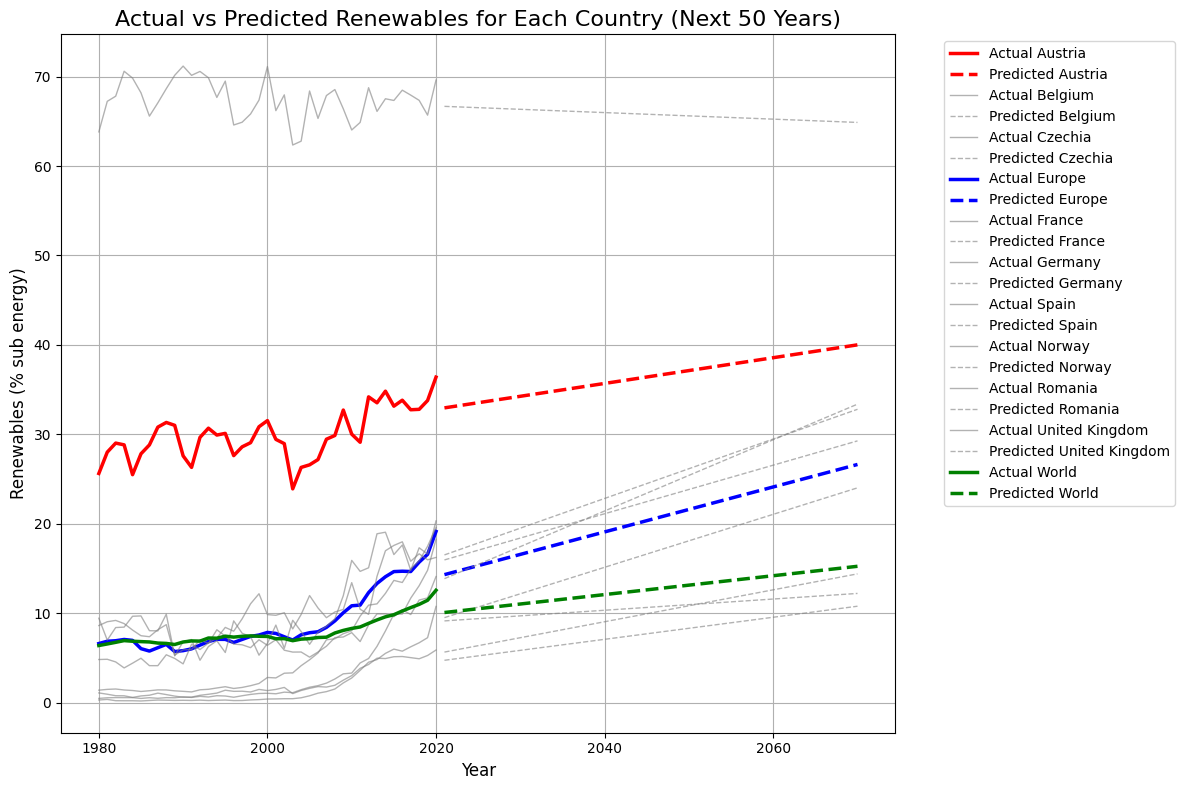

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Ensure data is sorted by 'Year'
df = data_filtered.sort_values(by=['Year'])

# Feature columns and scaler
X_columns = ['Year', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)', 'Other Renewables (% sub energy)']
scaler = StandardScaler()

# Lasso model with chosen alpha
best_alpha = 0.001  
lasso_model = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)

# Set up plot
plt.figure(figsize=(12, 8))

# Entities to highlight
highlighted_countries = ['Austria', 'Europe', 'World']
highlighted_styles = {
    'Austria': {'color': 'red', 'linewidth': 2.5},
    'Europe': {'color': 'blue', 'linewidth': 2.5},
    'World': {'color': 'green', 'linewidth': 2.5},
}

for country in countries:
    # Filter data for the current country
    country_df = df[df['Entity'] == country]
    
    # Prepare features (X) and target (y)
    X = country_df[X_columns]
    y = country_df['Renewables (% sub energy)']
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)

    # Fit the Lasso model
    lasso_model.fit(X_scaled, y)

    # Generate future years
    last_known_year = country_df['Year'].max()
    future_years = np.arange(last_known_year + 1, last_known_year + 51)

    # Predict future feature values
    future_data = []

    for feature in X_columns[1:]:  # Exclude 'Year'
        lr = LinearRegression()
        lr.fit(country_df[['Year']], country_df[feature])
        
        # Generate future years as a DataFrame with the same column name
        future_years_df = pd.DataFrame(future_years, columns=['Year'])
        future_feature_values = lr.predict(future_years_df)
        future_data.append(future_feature_values.flatten())

    # Combine future year and predicted features
    future_data = np.column_stack([future_years] + future_data)
    future_df = pd.DataFrame(future_data, columns=X_columns)

    # Scale future data and make predictions
    future_data_scaled = scaler.transform(future_df)
    future_predictions = lasso_model.predict(future_data_scaled)

    # Determine style for the current country
    if country in highlighted_countries:
        style = highlighted_styles[country]
        plt.plot(country_df['Year'], y, label=f'Actual {country}', **style)
        plt.plot(future_years, future_predictions, label=f'Predicted {country}', linestyle='--', **style)
    else:
        plt.plot(country_df['Year'], y, label=f'Actual {country}', color='gray', linewidth=1, alpha=0.6)
        plt.plot(future_years, future_predictions, label=f'Predicted {country}', linestyle='--', color='gray', linewidth=1, alpha=0.6)

# Add plot labels, legend, and grid
plt.xlabel('Year', fontsize=12)
plt.ylabel('Renewables (% sub energy)', fontsize=12)
plt.title('Actual vs Predicted Renewables for Each Country (Next 50 Years)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

